In [1]:
import torch
import foolbox as fb
import timm
from PIL import Image
from urllib.request import urlopen
import requests
import numpy as np
import torchvision as tivision

/home/michaelangelo/Benchmark-of-Methods-for-Adversarial-Attacks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mobile_model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
mobile_model = mobile_model.cuda().eval()

mobile_data_config = timm.data.resolve_model_data_config(mobile_model)
mobile_transforms = timm.data.create_transform(**mobile_data_config, is_training=False)

In [3]:
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = requests.get(url).json()

CARLINI WAGNER L2

In [39]:
def fool_model_with_cwl2(image_url: str, model):
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = 123

    label = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.TargetedMisclassification(label)

    attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=10,steps = 100, stepsize=0.1, confidence=0.0)
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [5]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_cwl2(    'https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg', mobile_model )


In [6]:
print(adversarial_label)
print(imagenet_labels[adversarial_label])

123
spiny lobster


In [7]:
print(success)
print(torch.softmax(mobile_model(raw_adversarial), dim=1).max())
print(torch.softmax(mobile_model(clipped_adversarial), dim=1).max())

tensor([False], device='cuda:0')
tensor(0.1417, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9927, device='cuda:0', grad_fn=<MaxBackward1>)


In [8]:
image_url = 'https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg'
image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
])

img = Image.open(urlopen(image_url))
img_tensor = image_transforms(img).unsqueeze(0).cuda()
    
print(torch.softmax(mobile_model(img_tensor), dim=1).max())

tensor(0.9826, device='cuda:0', grad_fn=<MaxBackward1>)


(1, 3, 224, 224)

np.float32(2.8718024e-09)

np.float32(0.94888973)

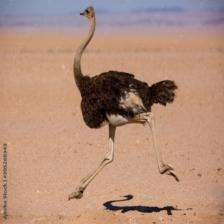

np.float32(2.0861626e-07)

np.float32(0.93958354)

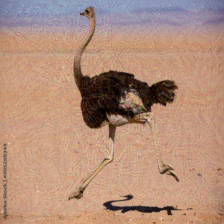

In [9]:
#dispaly shape of the clipped_adversarial

display(clipped_adversarial.cpu().detach().numpy().shape)
#display min and max value of clipped_adversarial
display(clipped_adversarial.cpu().detach().numpy().min())
display(clipped_adversarial.cpu().detach().numpy().max())
tivision.utils.save_image(clipped_adversarial, 'adversarial_image.jpg')
#display the image
Image.open('adversarial_image.jpg').show()
# display(raw_adversarial)
#min max value of raw_adversarial
display(raw_adversarial.cpu().detach().numpy().min())
display(raw_adversarial.cpu().detach().numpy().max())
tivision.transforms.ToPILImage()(raw_adversarial[0].detach().cpu()).show()


PGD

In [43]:
def fool_model_with_pgd(image_url: str, model):
    # model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)
    # print(f"Model is loaded on {device}")
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = 123

    label = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.TargetedMisclassification(label)

    attack = fb.attacks.LinfPGD()
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(clipped_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [11]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_pgd(    'https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg')
print(imagenet_labels[adversarial_label])

Model is loaded on cuda
spiny lobster


JSMA NOT AVAILABLE

HOPSKIPJUMP

In [70]:
def fool_model_with_hopskipjump(image_url: str,model, label=9):
    # model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
    # model.eval()
    # model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = label
    
    labels = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.Misclassification(labels=labels)

    attack = fb.attacks.HopSkipJumpAttack(steps=10,)
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [71]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_hopskipjump('https://transforms.stlzoo.org/production/animals/red-kangaroo-02-01.jpg?w=1200&h=1200&auto=compress%2Cformat&fit=crop&dm=1654795233&s=5f137aa9a410a7ea3386c6972265111d',mobile_model ,imagenet_labels.index('wallaby'))
print(imagenet_labels[adversarial_label])


coyote


DEEPFOOL

In [36]:
def fool_model_with_deepfool(image_url: str,model, label=9):
    # model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
    # model.eval()
    # model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = label
    
    labels = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.Misclassification(labels=labels)

    attack = fb.attacks.L2DeepFoolAttack(steps=100, candidates=10, overshoot=0.000001, )
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [22]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_deepfool('https://transforms.stlzoo.org/production/animals/red-kangaroo-02-01.jpg?w=1200&h=1200&auto=compress%2Cformat&fit=crop&dm=1654795233&s=5f137aa9a410a7ea3386c6972265111d', imagenet_labels.index('wallaby'))
print(imagenet_labels[adversarial_label])

coyote


EADEN

In [35]:
def fool_model_with_eaden(image_url: str,model, label=9):
    # model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
    # model.eval()
    # model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = label
    
    labels = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.Misclassification(labels=labels)

    attack = fb.attacks.EADAttack(binary_search_steps=10, steps=10,decision_rule='EN', )
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [17]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_eaden('https://transforms.stlzoo.org/production/animals/red-kangaroo-02-01.jpg?w=1200&h=1200&auto=compress%2Cformat&fit=crop&dm=1654795233&s=5f137aa9a410a7ea3386c6972265111d', imagenet_labels.index('dingo'))
print(imagenet_labels[adversarial_label])

wallaby


VAM

In [33]:
def fool_model_with_VAM(image_url: str,model, label=9):
    # model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
    # model.eval()
    # model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()
    

    np_arr = np.zeros(1)
    np_arr[0] = label
    
    labels = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.Misclassification(labels=labels)

    attack = fb.attacks.EADAttack(binary_search_steps=10, steps=10,decision_rule='EN', )
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [ ]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_VAM('https://transforms.stlzoo.org/production/animals/red-kangaroo-02-01.jpg?w=1200&h=1200&auto=compress%2Cformat&fit=crop&dm=1654795233&s=5f137aa9a410a7ea3386c6972265111d', imagenet_labels.index('wallaby'))
print(imagenet_labels[adversarial_label])

wallaby


SUMMARY

In [25]:
import time
import numpy as np
import pandas as pd

In [65]:
def benchmark_methods(methods: dict, image_url: str, model):
    """
    Benchmark a set of adversarial attack methods.

    Args:
        methods (dict): Dictionary of attack methods {method_name: function}.
        image_url (str): URL of the input image.
        model: Pretrained model to attack.

    Returns:
        pd.DataFrame: Benchmarking results as a tidy table.
    """
    results = []

    for method_name, method in methods.items():
        times = []
        probabilities_before = []
        probabilities_after = []
        label_before = []
        label_after = []
        # successes = []

        print(f"Benchmarking {method_name}...")

        for _ in range(3):  # Run each method 3 times
            start_time = time.time()
            
            # Run the adversarial method
            outputs = method(image_url, model)
            raw_adversarial, clipped_adversarial, _, label, adversarial_label = outputs
            
            img = Image.open(urlopen(image_url))
            input_tensor = image_transforms(img).unsqueeze(0).cuda()
            
            
            # Measure time
            elapsed_time = time.time() - start_time
            times.append(elapsed_time)
            
            # Collect probabilities
            with torch.no_grad():
                # For the original input
                logits_before = model(input_tensor)
                probabilities_before_run = torch.nn.functional.softmax(logits_before, dim=1)
                probabilities_before.append(torch.max(probabilities_before_run).cpu().detach().numpy())
                label_before.append(int(torch.argmax(logits_before).cpu().detach().numpy()))
                
                

                # For the adversarial input
                logits_after = model(raw_adversarial)
                probabilities_after_run = torch.nn.functional.softmax(logits_after, dim=1)
                probabilities_after.append(torch.max(probabilities_after_run).cpu().detach().numpy())
                label_after.append(int(torch.argmax(logits_after).cpu().detach().numpy()))
                
            
            # Track success
            # successes.append(success)
        
        # Store results for this method
        results.append({
            "Method": method_name,
            "Avg Time (s)": np.mean(times),
            "Avg Prob Before": np.mean(probabilities_before),
            "Avg Prob After": np.mean(probabilities_after),
            "Predicted Label Before": label_before,
            "Predicted Label After": label_after,
            # "Success Rate": np.mean(successes),
        })

    # Convert to DataFrame for a tidy table
    return pd.DataFrame(results)

In [66]:
methods = {
    "CW_L2": fool_model_with_cwl2,
    "PGD": fool_model_with_pgd,
    "HopSkipJump": fool_model_with_hopskipjump,
    "DeepFool": fool_model_with_deepfool,
    "EAD_EN": fool_model_with_eaden,
    "VAM": fool_model_with_VAM,
}

# Image and pretrained model (replace with actual inputs)
image_url ='https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg'  # Replace with actual image path
# model = load_pretrained_model()  # Replace with actual model loader

# Run benchmarking
benchmark_results = benchmark_methods(methods, image_url, mobile_model)

# Display results as a tidy table
print(benchmark_results)

Benchmarking CW_L2...
Benchmarking PGD...
Benchmarking HopSkipJump...
Benchmarking DeepFool...
Benchmarking EAD_EN...
Benchmarking VAM...
        Method  Avg Time (s)  Avg Prob Before  Avg Prob After  \
0        CW_L2      1.599943         0.982641        0.360494   
1          PGD      0.899073         0.982641        0.999996   
2  HopSkipJump      7.887900         0.982641        0.224964   
3     DeepFool      0.946811         0.982641        0.446972   
4       EAD_EN      0.985561         0.982641        0.482374   
5          VAM      0.998743         0.982641        0.482374   

  Predicted Label Before Predicted Label After  
0              [9, 9, 9]       [123, 123, 123]  
1              [9, 9, 9]       [123, 123, 123]  
2              [9, 9, 9]           [6, 134, 6]  
3              [9, 9, 9]       [138, 138, 138]  
4              [9, 9, 9]       [138, 138, 138]  
5              [9, 9, 9]       [138, 138, 138]  


In [67]:
display(benchmark_results)

,Method,Avg Time (s),Avg Prob Before,Avg Prob After,Predicted Label Before,Predicted Label After
0,CW_L2,1.599943,0.982641,0.360494,"[9, 9, 9]","[123, 123, 123]"
1,PGD,0.899073,0.982641,0.999996,"[9, 9, 9]","[123, 123, 123]"
2,HopSkipJump,7.887900,0.982641,0.224964,"[9, 9, 9]","[6, 134, 6]"
3,DeepFool,0.946811,0.982641,0.446972,"[9, 9, 9]","[138, 138, 138]"
4,EAD_EN,0.985561,0.982641,0.482374,"[9, 9, 9]","[138, 138, 138]"
5,VAM,0.998743,0.982641,0.482374,"[9, 9, 9]","[138, 138, 138]"
